<h1><div class="alert alert-block alert-info">
    Churn Analysis
</div></h1>

## Objective

<hr>

Analyse the churn of a Telecommunication company in order to find out what are the relevant variables to be analysed to develop a customer retention program.

## Description of the Data

<hr>

The raw data contains 7043 rows (customers) and 21 columns (features). The data is right-censored, considering tenure as the time in months and churn represents the status at the end of the study.

The metadata can be divided into the following groups:

- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents
- Censoring - customers who left within the last month – the event is stored in the column called Churn and the time to it is on column tenure. 

Source: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
options( warn = 2 )
options(repr.plot.width=16, repr.plot.height=10)

In [2]:
library(dplyr) 
library(survival)
library(ggplot2)
library(survminer)
library(glmnet)
library(corrplot)
library(RColorBrewer)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggpubr

Loading required package: magrittr

Loading required package: Matrix

Loaded glmnet 3.0-2


corrplot 0.84 loaded



## Loading and Cleaning the Data

<hr>

In [3]:
churn = read.csv('WA_Fn-UseC_-Telco-Customer-Churn.csv',header = TRUE, sep = ',')

In [4]:
glimpse(churn)

Observations: 7,043
Variables: 21
$ customerID       <fct> 7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 92...
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fe...
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No,...
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No,...
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49...
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes...
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Ye...
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fibe...
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, ...
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No...
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No...
$ TechSupport     

### Description of the variables

- <i>Customer ID:</i> Customer ID
- <i>Gender:</i> Whether the customer is a male or a female
- <i>Senior Citizen:</i> Whether the customer is a senior citizen or not (1, 0)
- <i>Partner:</i> Whether the customer has a partner or not (Yes, No)
- <i>Dependents:</i> Whether the customer has dependents or not (Yes, No)
- <i>Tenure:</i> Number of months the customer has stayed with the company
- <i>Phone Service:</i> Whether the customer has a phone service or not (Yes, No)
- <i>Multiple Lines:</i> Whether the customer has multiple lines or not (Yes, No, No phone service)
- <i>Internet Service Customer’s:</i> internet service provider (DSL, Fiber optic, No)
- <i>Online Security:</i> Whether the customer has online security or not (Yes, No, No internet service)
- <i>Online Backup:</i> Whether the customer has online backup or not (Yes, No, No internet service)
- <i>Device Protection:</i> Whether the customer has device protection or not (Yes, No, No internet service)
- <i>Tech Support:</i> Whether the customer has tech support or not (Yes, No, No internet service)
- <i>Streaming TV:</i> Whether the customer has streaming TV or not (Yes, No, No internet service)
- <i>Streaming Movies:</i> Whether the customer has streaming movies or not (Yes, No, No internet service)
- <i>Contract:</i> The contract term of the customer (Month-to-month, One year, Two year)
- <i>Paperless Billing:</i> Whether the customer has paperless billing or not (Yes, No)
- <i>Payment Method:</i> The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- <i>Monthly Charges:</i> The amount charged to the customer monthly
- <i>Total Charges:</i> The total amount charged to the customer
- <i>Churn:</i> Whether the customer churned or not (Yes or No)

In [5]:
head(churn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


### Dealing with NAs

We have only 11 rows with NA values, that are in the column 'TotalCharges'. As we can see the 'TotalCharges' is closely dependent on Monthly Charges, so we are going to use just Monthly Charges in our study.

In [6]:
sum(is.na(churn))

[1] 11

In [7]:
df_sub = subset(churn, is.na(churn$TotalCharges) == FALSE)
df_sub$calculated_total = df_sub$MonthlyCharges*df_sub$tenure

sum_of_total = sum(df_sub$TotalCharges)
sum_calculated_total = sum(df_sub$calculated_total)
paste("Proportion of total charges explained by Tenure times Monthly Charges:", 
      paste((100*sum_calculated_total/sum_of_total),"%"))

[1] "Proportion of total charges explained by Tenure times Monthly Charges: 99.9932907406485 %"

In [8]:
# Remove the column TotalCharges of the dataframe
churn = select(churn, -TotalCharges)
summary(churn)

      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

### Adapting variables

For the Surv function the status indicator needs to be a 0=alive, 1=dead variable, so we introduce the variable Event based on the Churn.

Senior Citizen by the description of the data is categorical and was loaded as integer, so we adapt it.

In [9]:
churn = churn %>% mutate(event = ifelse(Churn=='No', 0, 1),
                SeniorCitizen = as.factor(SeniorCitizen)
                )

### Visualizing the data

Analyzing the variables effect on the tenure we can have an initial idea of which ones are important to explain the customers behaviour.

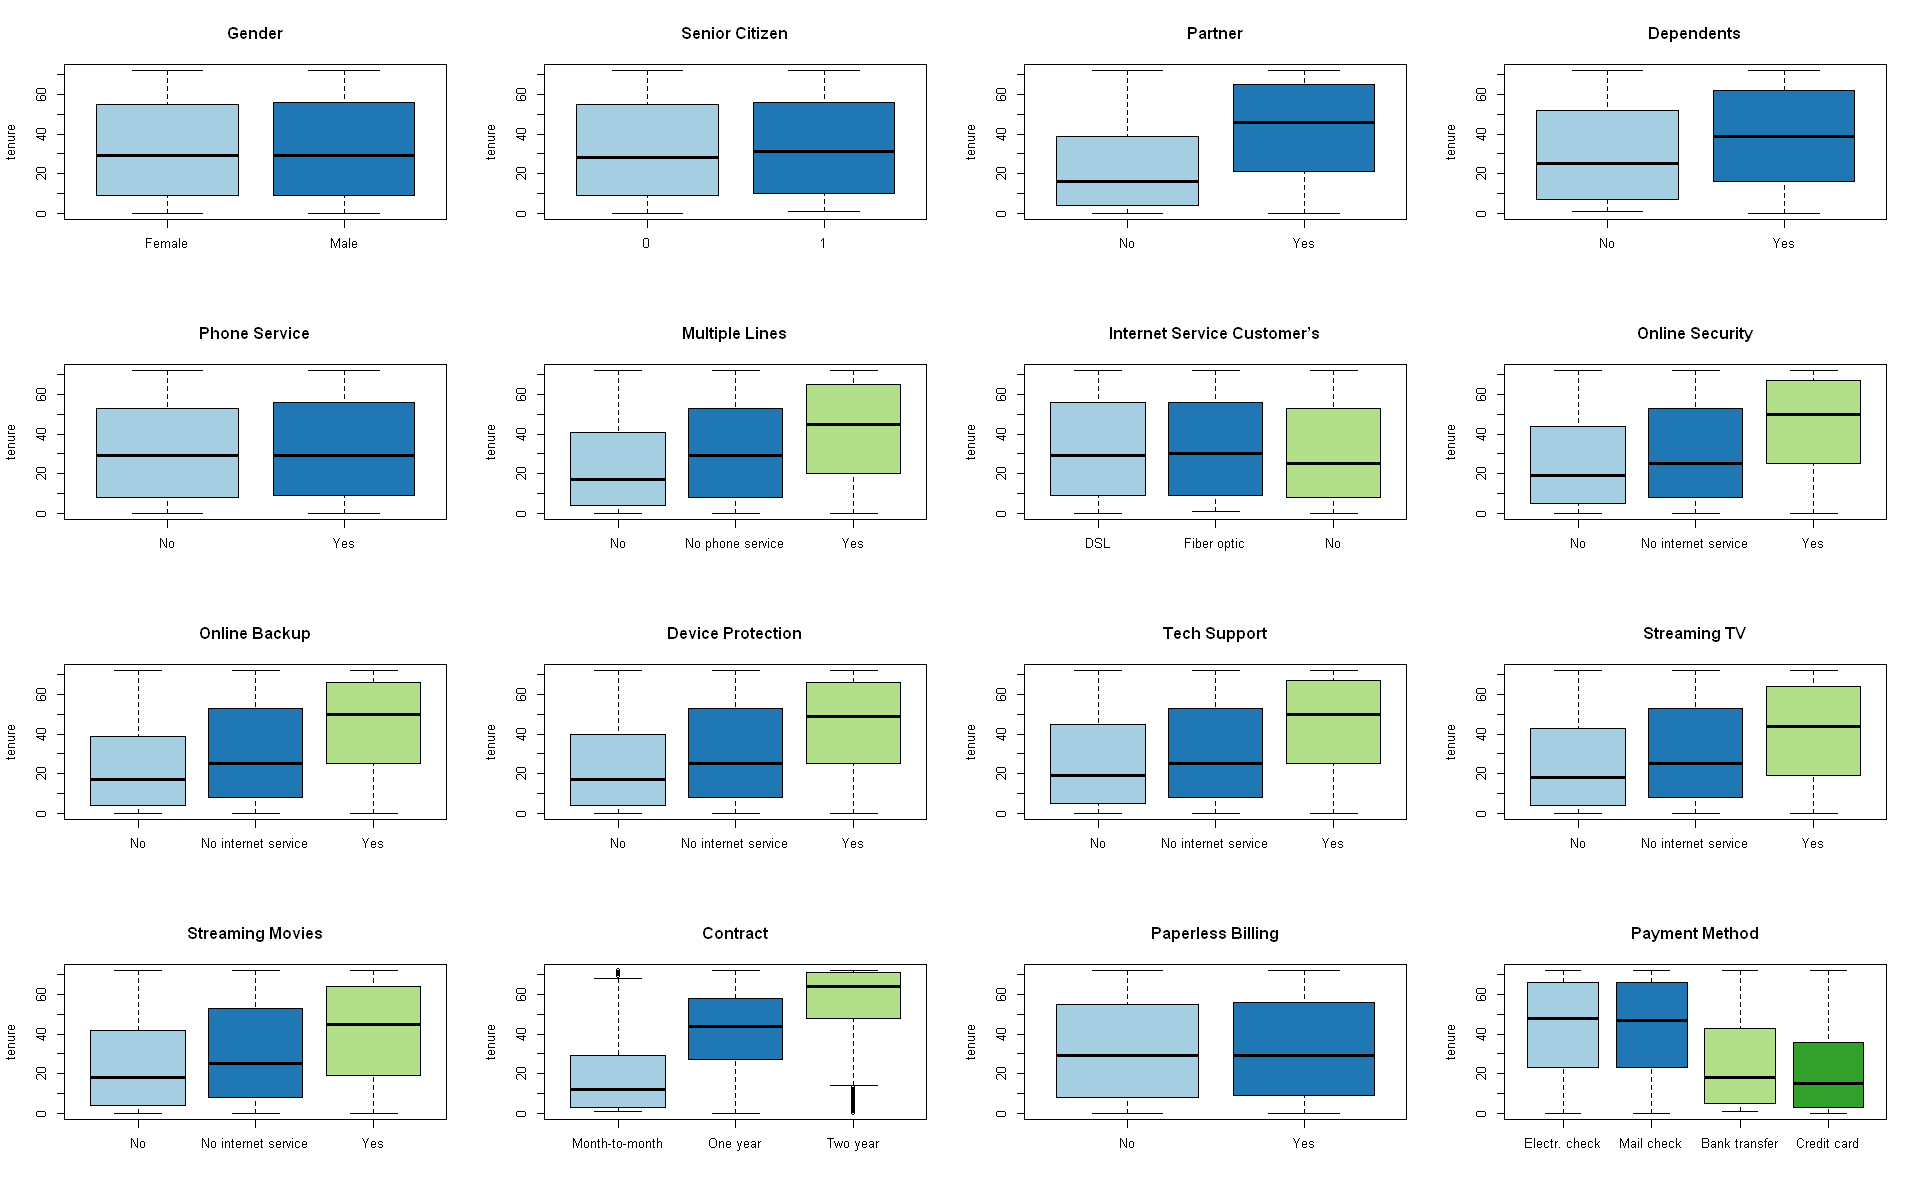

In [10]:
par(mfrow=c(4,4))

myPalette <- brewer.pal(5, "Paired") 

boxplot(tenure~gender, data=churn, xlab = "", col=myPalette, main="Gender")
boxplot(tenure~SeniorCitizen, data=churn, xlab = "", col=myPalette, main="Senior Citizen")
boxplot(tenure~Partner, data=churn, xlab = "", col=myPalette, main="Partner")
boxplot(tenure~Dependents, data=churn, xlab = "", col=myPalette, main="Dependents")

boxplot(tenure~PhoneService, data=churn, xlab = "", col=myPalette, main="Phone Service")
boxplot(tenure~MultipleLines, data=churn, xlab = "", col=myPalette, main="Multiple Lines")
boxplot(tenure~InternetService, data=churn, xlab = "", col=myPalette, main="Internet Service Customer’s")
boxplot(tenure~OnlineSecurity, data=churn, xlab = "",col=myPalette,  main="Online Security")

boxplot(tenure~OnlineBackup, data=churn, xlab = "", col=myPalette, main="Online Backup")
boxplot(tenure~DeviceProtection, data=churn, xlab = "", col=myPalette, main="Device Protection")
boxplot(tenure~TechSupport, data=churn, xlab = "", col=myPalette,  main="Tech Support")
boxplot(tenure~StreamingTV, data=churn, xlab = "", col=myPalette, main="Streaming TV")

boxplot(tenure~StreamingMovies, data=churn, xlab = "", col=myPalette,  main="Streaming Movies")
boxplot(tenure~Contract, data=churn, xlab = "", col=myPalette,  main="Contract")
boxplot(tenure~PaperlessBilling, data=churn, xlab = "", col=myPalette,  main="Paperless Billing")
boxplot(tenure~PaymentMethod, data=churn, xlab = "", col=myPalette, main="Payment Method", names = c('Electr. check', 'Mail check', 'Bank transfer', 'Credit card'))


It seems that we can not stablish a linear relation between charges and tenure, as we can see in the chart below:

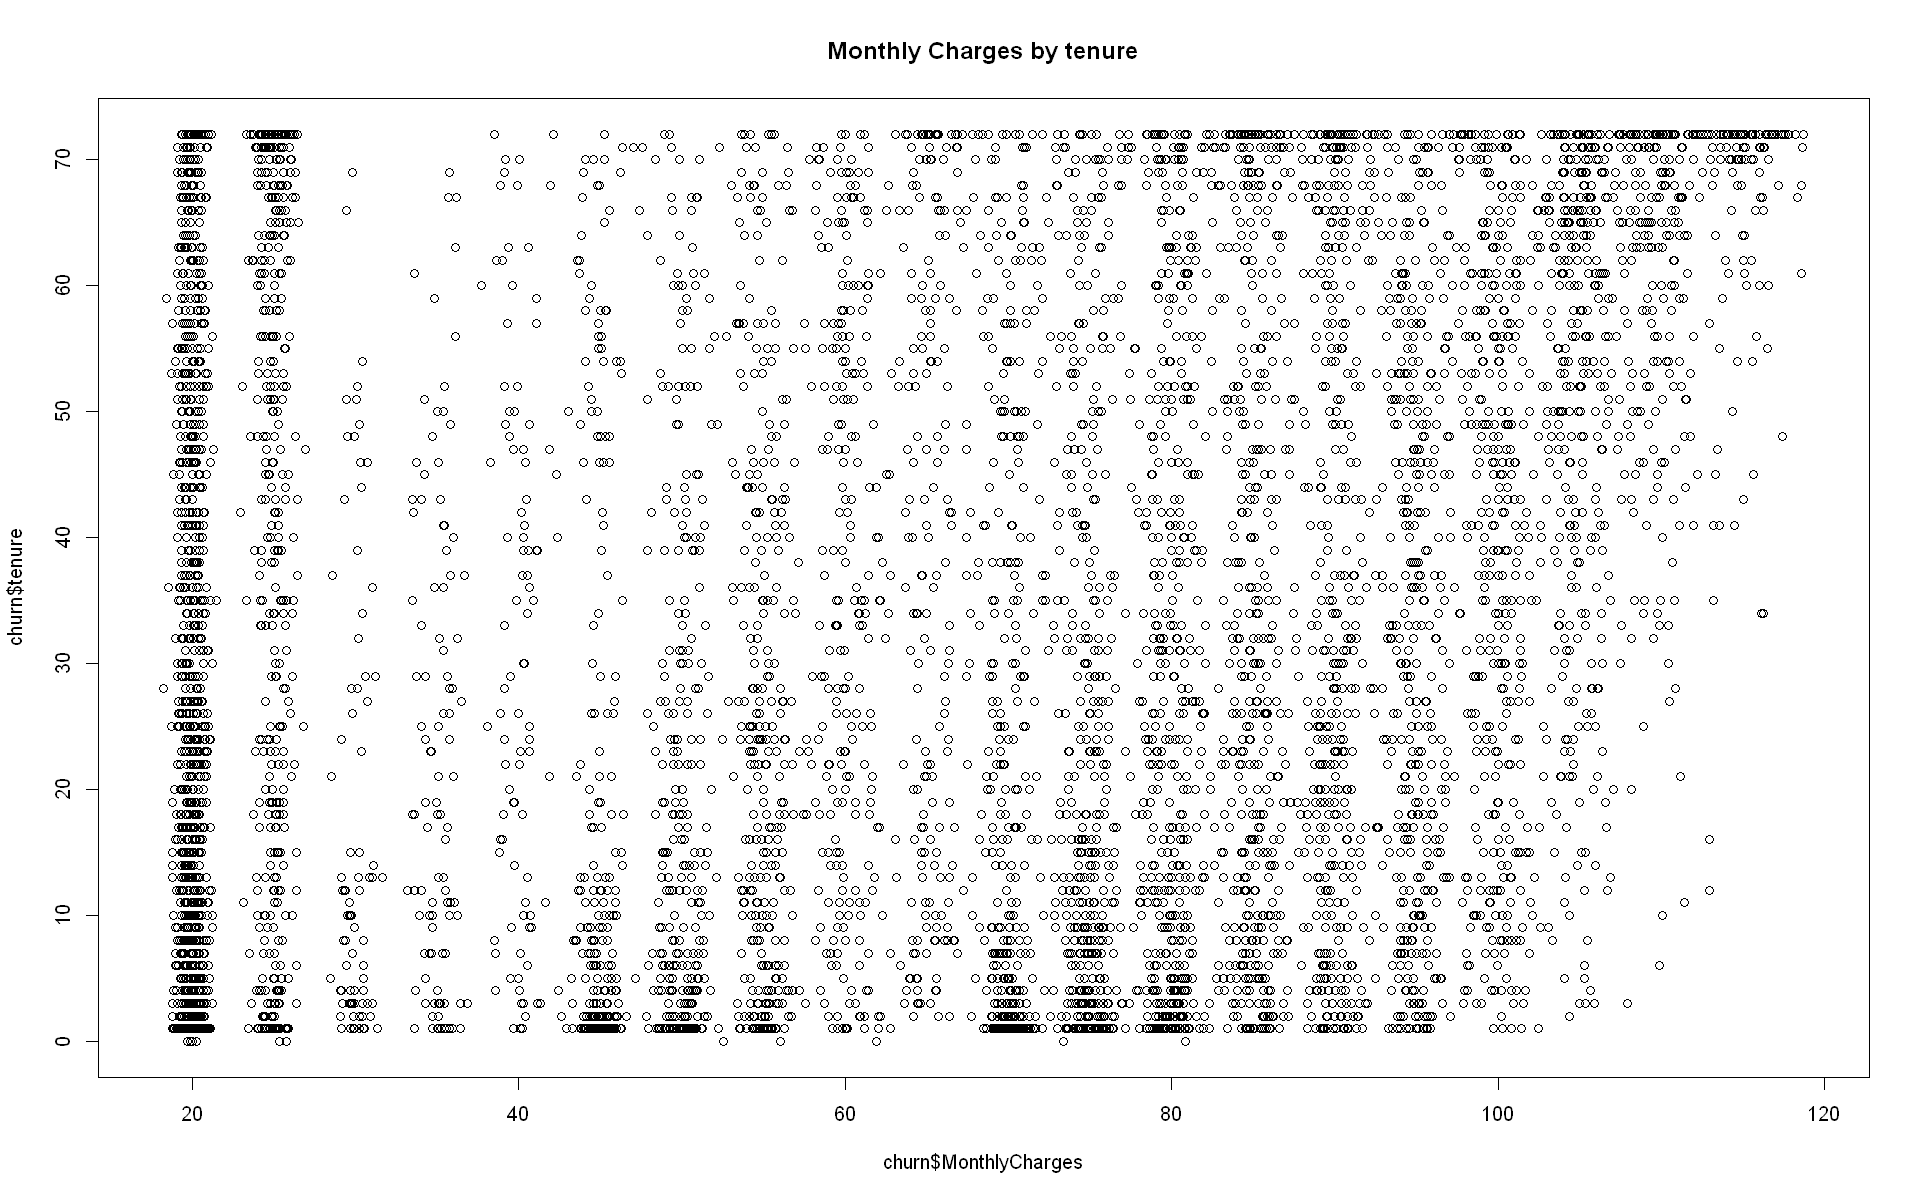

In [11]:
plot(churn$MonthlyCharges, churn$tenure, main= 'Monthly Charges by tenure')

# Analysis
<hr>

## Monthly charges

Let's explore to check the assumption that monthly charge is dependent on the other variables of the data set. To do so we ran a linear regression to check this hypothesis, and by analyzing the adjusted R-squared we can say that this is a good model to predict monthly charges, but it could be improved removing some variables that are not significative to the model.

In [12]:
lm.model = lm(MonthlyCharges ~ gender + SeniorCitizen + Partner + 
                          Dependents + PhoneService + MultipleLines + InternetService +
                          OnlineSecurity +OnlineBackup+DeviceProtection + 
                          TechSupport + StreamingTV + StreamingMovies + Contract +
                          PaperlessBilling + PaymentMethod, data =churn)
summary(lm.model)


Call:
lm(formula = MonthlyCharges ~ gender + SeniorCitizen + Partner + 
    Dependents + PhoneService + MultipleLines + InternetService + 
    OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + 
    StreamingTV + StreamingMovies + Contract + PaperlessBilling + 
    PaymentMethod, data = churn)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2309 -0.6144 -0.0057  0.6080  4.8404 

Coefficients: (7 not defined because of singularities)
                                       Estimate Std. Error  t value Pr(>|t|)
(Intercept)                           24.968629   0.057368  435.235   <2e-16
genderMale                             0.023526   0.024466    0.962    0.336
SeniorCitizen1                         0.014370   0.035572    0.404    0.686
PartnerYes                            -0.038667   0.029004   -1.333    0.183
DependentsYes                          0.013077   0.031347    0.417    0.677
PhoneServiceYes                       20.050301   0.047992  417.781   <2e-16
M

Removing the variables related to customer and contract categories we achieve a model of charges based on services with an excelent fit (shown by the adjusted R-squared). We conclude that we don't need to use Monthly Charges to build our survival analysis because this information is already captured by the services.

In [13]:
lm.model = lm(MonthlyCharges ~ PhoneService + MultipleLines + InternetService +
                          OnlineSecurity +OnlineBackup+DeviceProtection + 
                          TechSupport + StreamingTV + StreamingMovies, data =churn)
summary(lm.model)


Call:
lm(formula = MonthlyCharges ~ PhoneService + MultipleLines + 
    InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + 
    TechSupport + StreamingTV + StreamingMovies, data = churn)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2527 -0.6132 -0.0059  0.6003  4.7973 

Coefficients: (7 not defined because of singularities)
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          24.95251    0.04478   557.2   <2e-16 ***
PhoneServiceYes                      20.05241    0.04783   419.2   <2e-16 ***
MultipleLinesNo phone service              NA         NA      NA       NA    
MultipleLinesYes                      5.01220    0.02815   178.0   <2e-16 ***
InternetServiceFiber optic           24.95737    0.03356   743.6   <2e-16 ***
InternetServiceNo                   -25.04904    0.04261  -587.9   <2e-16 ***
OnlineSecurityNo internet service          NA         NA      NA       NA    
OnlineSecurityYes   

## Kaplan-Meir (non-paramatric modeling)

We can observe in the Kaplan-Meier chart that in one year the company lost in the first year 15% of customer, 6% in the second year and 4% in the third year.

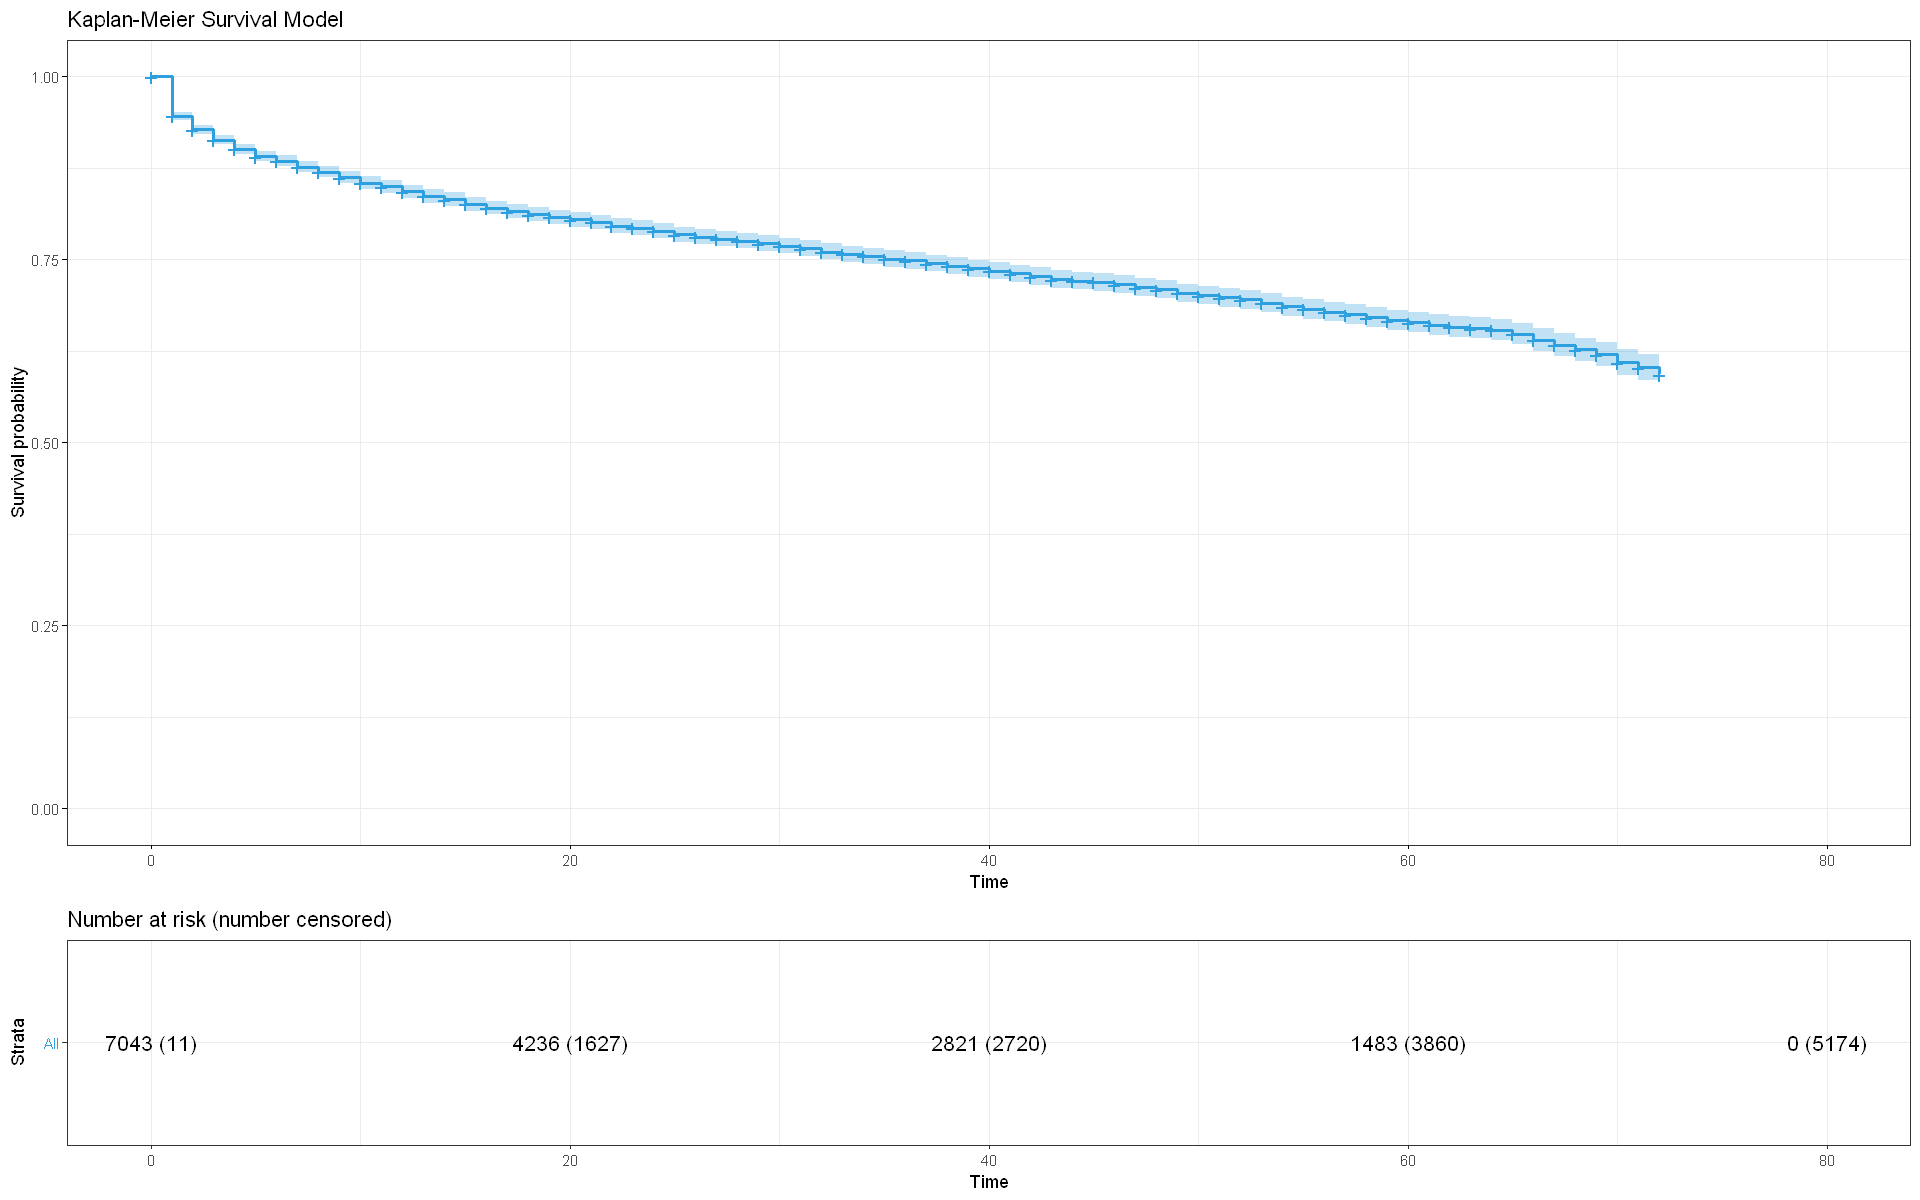

In [14]:
km.model <- survfit(Surv(churn$tenure, churn$event)~1, data = churn, type="kaplan-meier")
ggsurvplot(km.model,
          risk.table = "nrisk_cumcensor", # Add risk table
          ggtheme = theme_bw(), # Change ggplot2 theme
          palette = c("#2E9FDF"),
          title ='Kaplan-Meier Survival Model', 
          legend = 'none')

#### a) Demographic Analysis

We used the Logrank test to confirm Kaplan-Meier estimation that gender do not have a different pattern in relation to customer retention.  

By observing the Kaplan-Meier charts we see that there is higher hazard of churn customers without partners, seniors and without dependents.

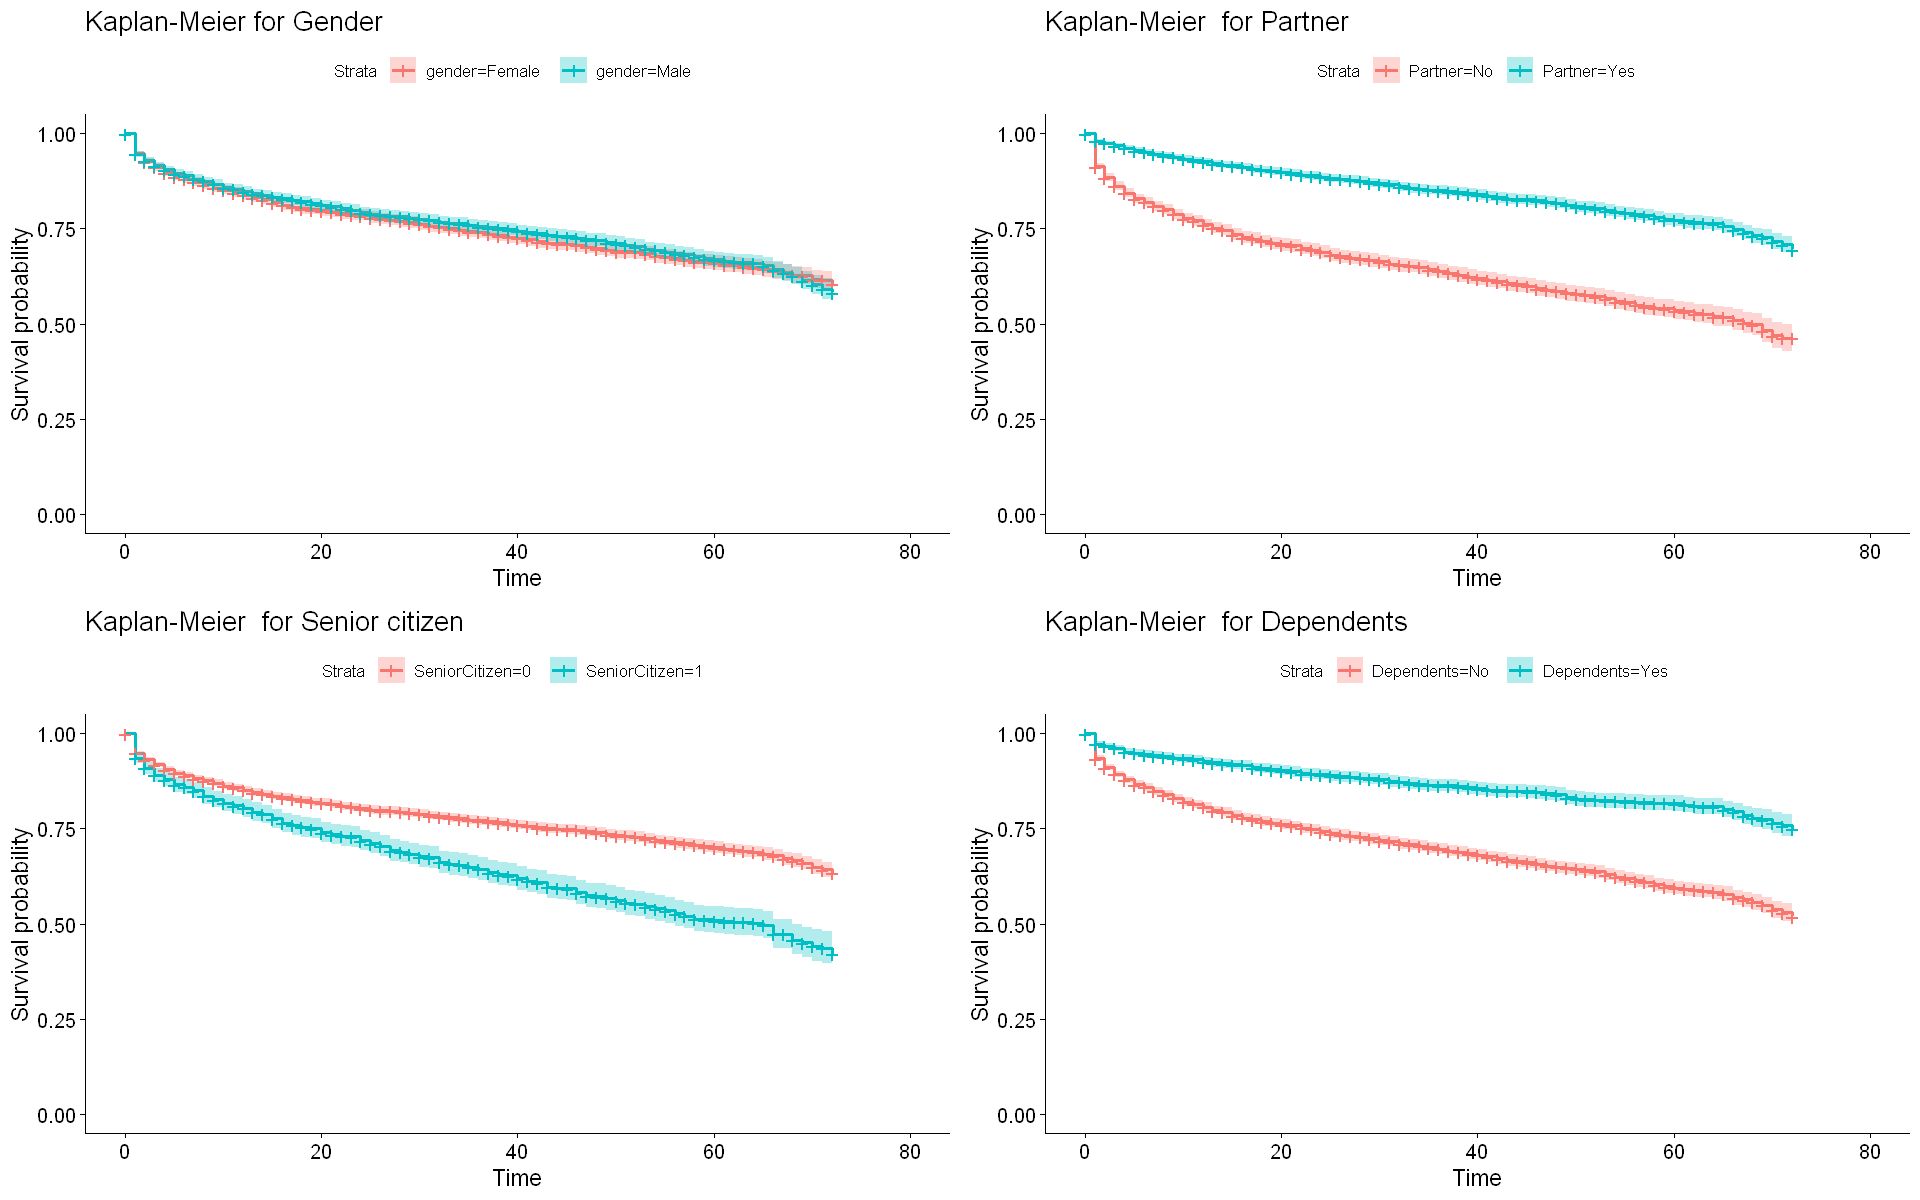

In [15]:
d_splots <- list()
d_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ gender, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Gender', xlab = 'Time')
d_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ SeniorCitizen, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Senior citizen', xlab = 'Time')
d_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ Partner, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Partner', xlab = 'Time')
d_splots[[4]] = ggsurvplot(survfit(Surv(tenure, event) ~ Dependents, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Dependents', xlab = 'Time')

arrange_ggsurvplots(d_splots, nrow = 2, ncol = 2)

In [16]:
#Logrank for Gender
survdiff(Surv(tenure, event) ~ gender, data = churn)

Call:
survdiff(formula = Surv(tenure, event) ~ gender, data = churn)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
gender=Female 3488      939      923     0.261     0.526
gender=Male   3555      930      946     0.255     0.526

 Chisq= 0.5  on 1 degrees of freedom, p= 0.5 

#### b) Customer Account Analysis

It is impressive the difference on hazard that comes from month-to-month contracts when compared to the other types. We can also observe the same trend when electronic checks are used as payment method. An surprising indicator is that customer who do not receive paper bills have lower survival time.

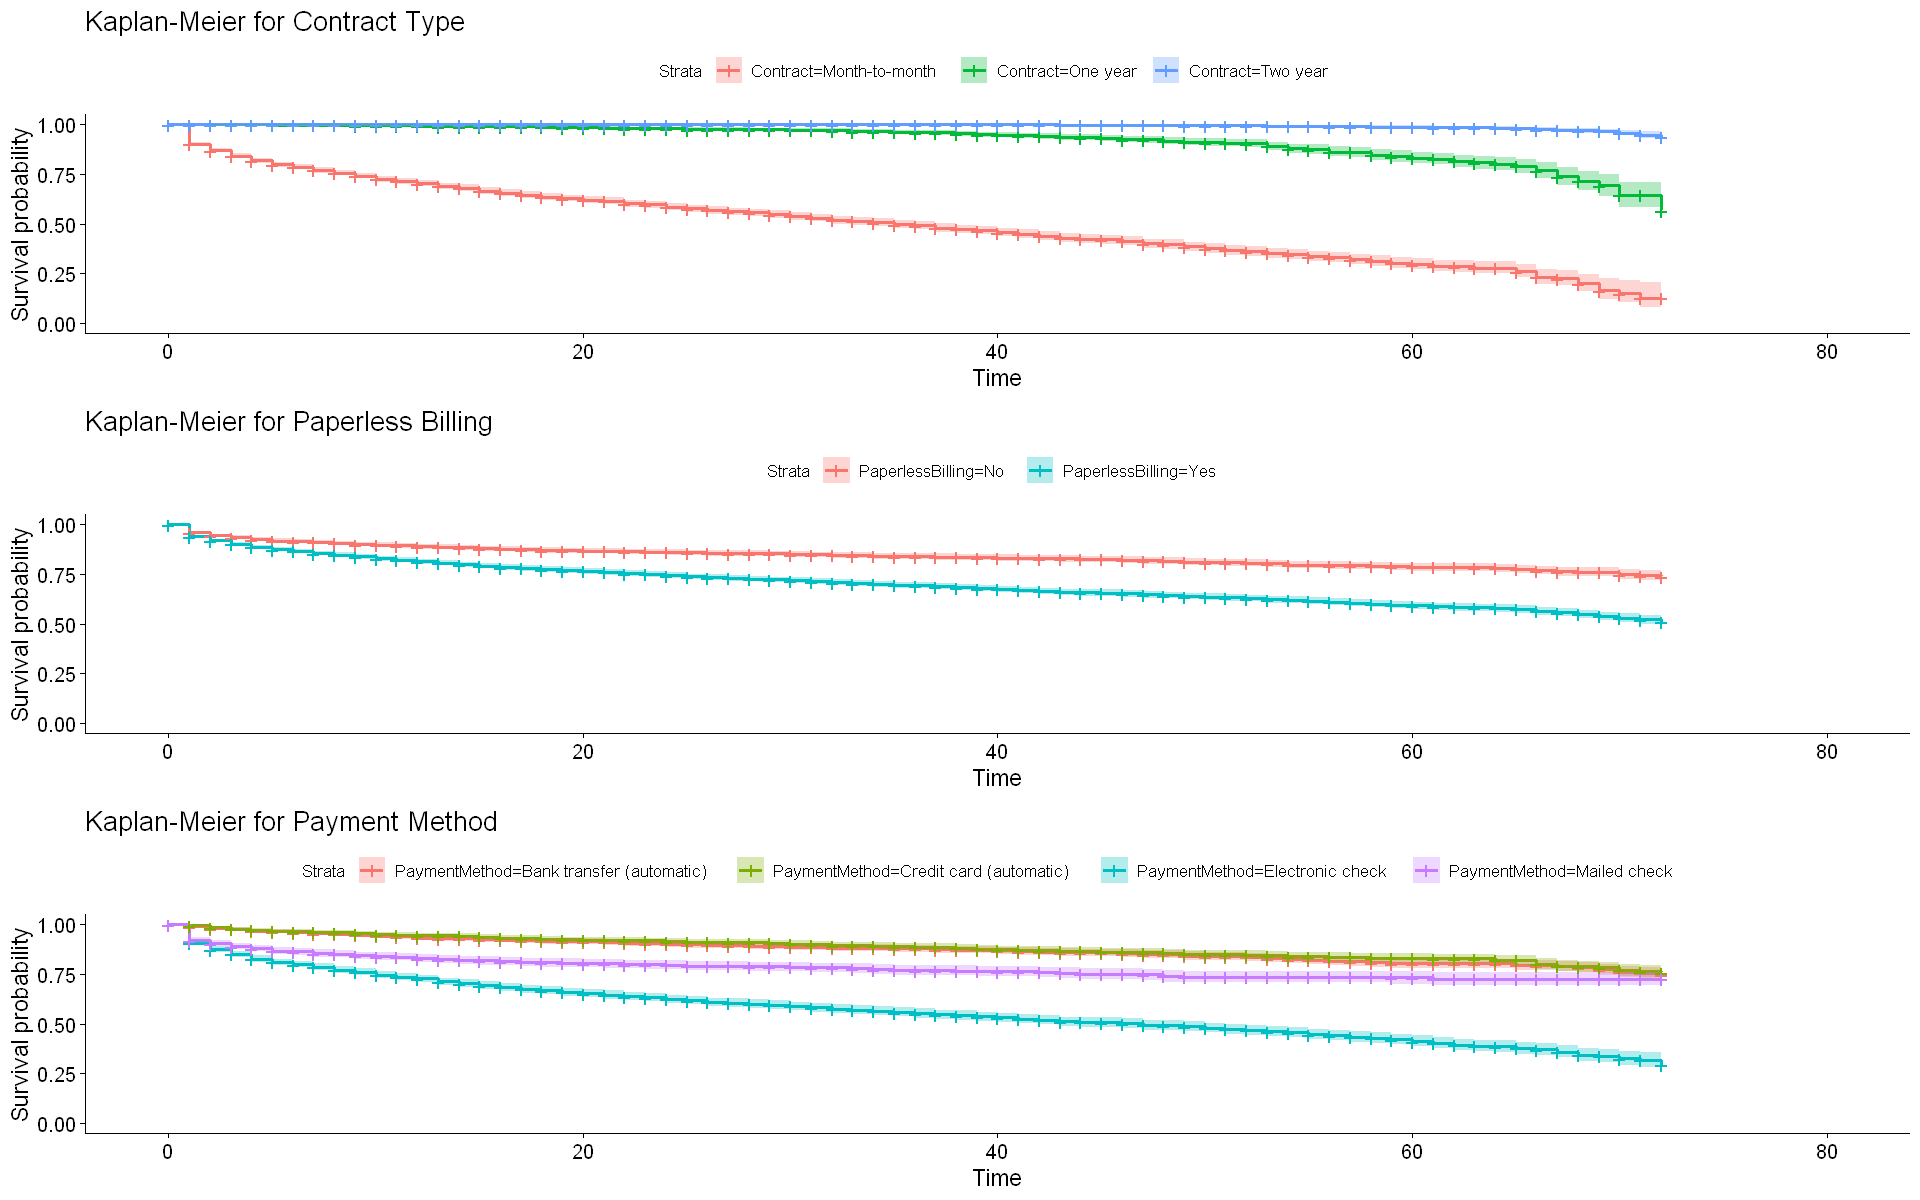

In [17]:
c_splots <- list()

c_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ Contract, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Contract Type', xlab = 'Time')  
c_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ PaperlessBilling, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Paperless Billing', xlab = 'Time')
c_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ PaymentMethod, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Payment Method', xlab = 'Time')

arrange_ggsurvplots(c_splots, nrow = 3, ncol = 1)

#### c) Services Analysis

We used the Logrank test to confirm Kaplan-Meier estimation that phone service do not have a different pattern in relation to customer retention.

One interesting finding from the survival curves is that customer without internet service have higher survival time when compared to those who contracted this service. The inexistance of technical support is also a factor that increases the hazard when compared to other categories. 

The absence of services related to risk mitigation in the perspective of the consumer (device protection, online security and online backup) represent higher hazard of churn.

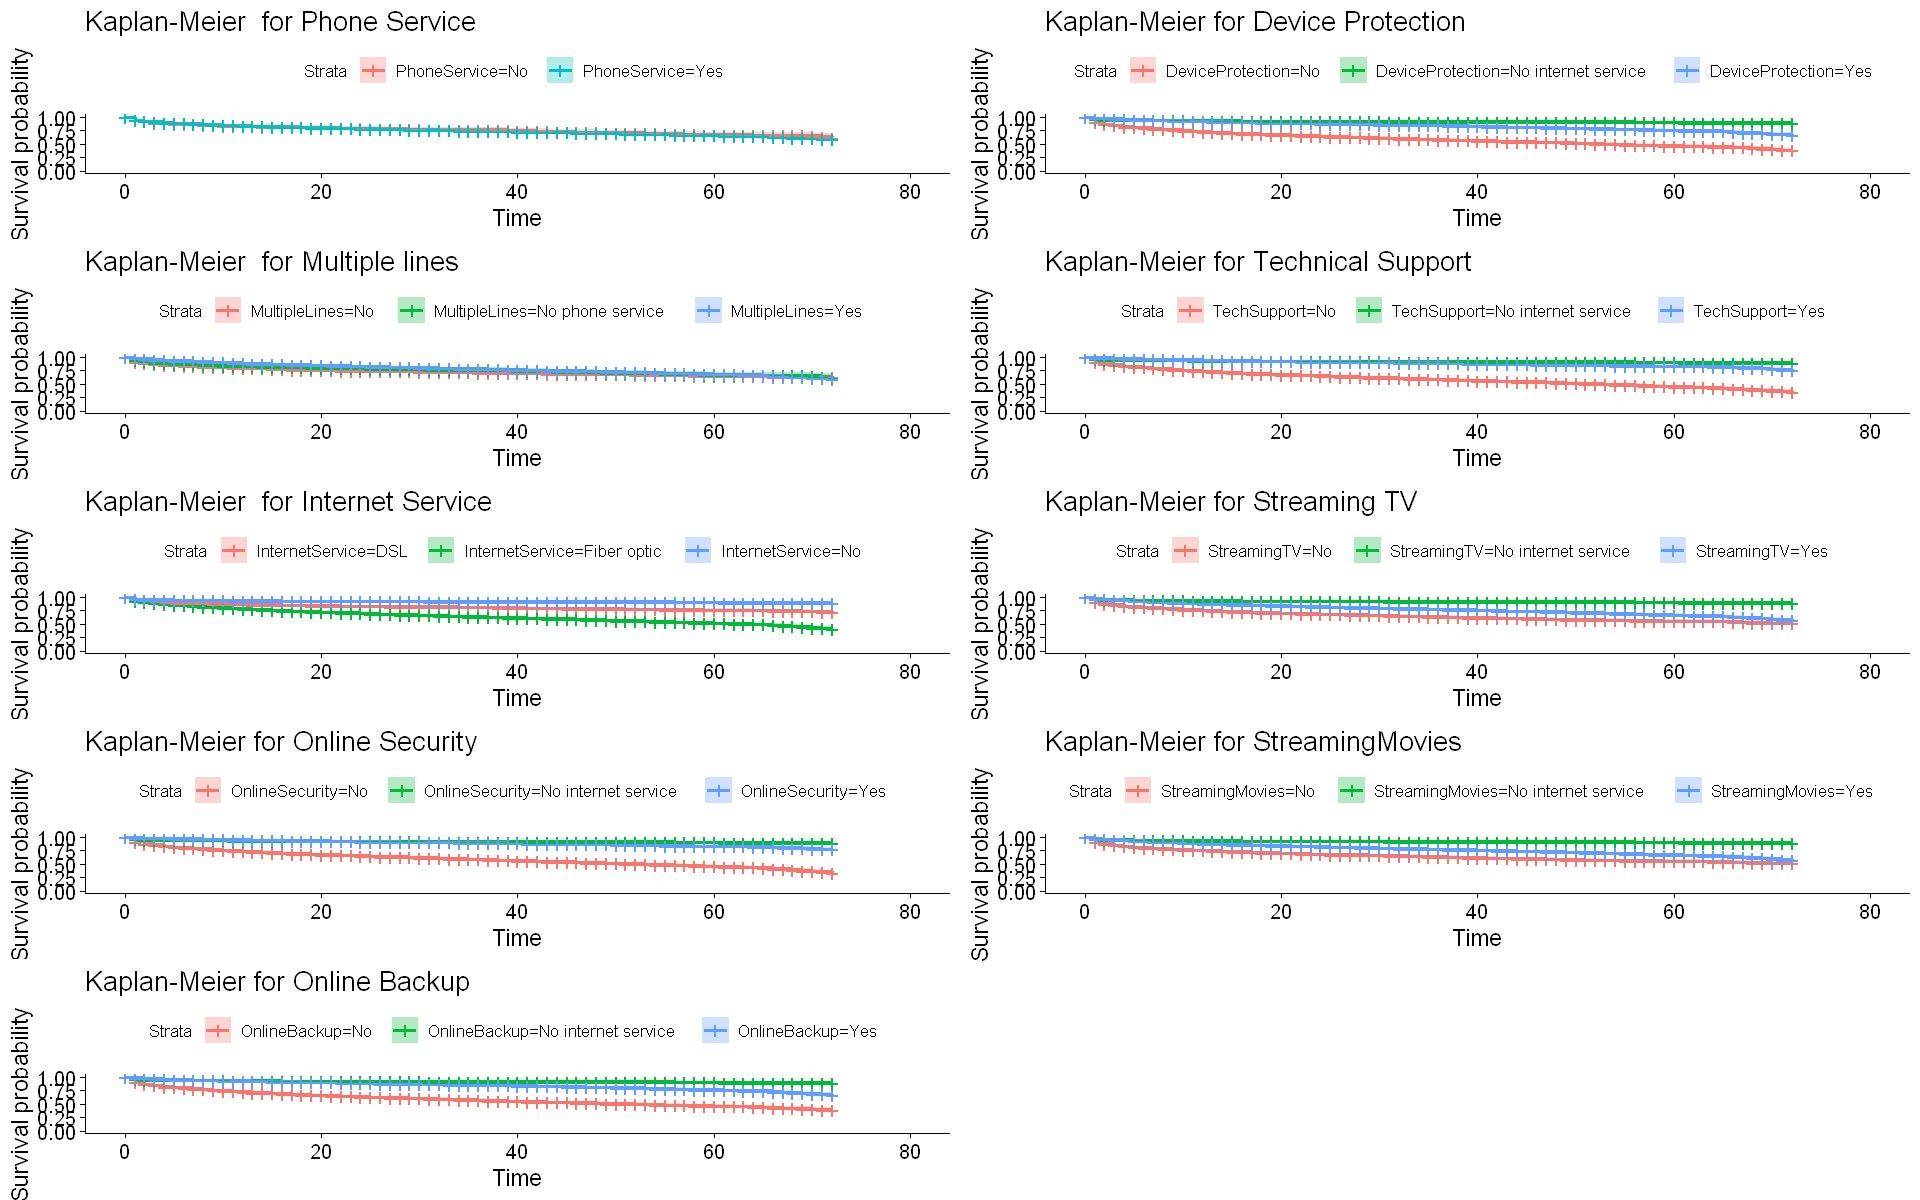

In [18]:
s_splots <- list()
s_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ PhoneService, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Phone Service', xlab = 'Time')
s_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ MultipleLines, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Multiple lines', xlab = 'Time')
s_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ InternetService, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Internet Service', xlab = 'Time')
s_splots[[4]] = ggsurvplot(survfit(Surv(tenure, event) ~ OnlineSecurity, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Online Security', xlab = 'Time')
s_splots[[5]] = ggsurvplot(survfit(Surv(tenure, event) ~ OnlineBackup, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Online Backup', xlab = 'Time')
s_splots[[6]] = ggsurvplot(survfit(Surv(tenure, event) ~ DeviceProtection, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Device Protection', xlab = 'Time')
s_splots[[7]] = ggsurvplot(survfit(Surv(tenure, event) ~ TechSupport, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Technical Support', xlab = 'Time')
s_splots[[8]] = ggsurvplot(survfit(Surv(tenure, event) ~ StreamingTV, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Streaming TV', xlab = 'Time')
s_splots[[9]] = ggsurvplot(survfit(Surv(tenure, event) ~ StreamingMovies, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for StreamingMovies', xlab = 'Time')
arrange_ggsurvplots(s_splots, nrow = 5, ncol = 2)

In [19]:
#Logrank for Phone Service
survdiff(Surv(tenure, event) ~ PhoneService, data = churn)

Call:
survdiff(formula = Surv(tenure, event) ~ PhoneService, data = churn)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
PhoneService=No   682      170      178    0.3828     0.431
PhoneService=Yes 6361     1699     1691    0.0404     0.431

 Chisq= 0.4  on 1 degrees of freedom, p= 0.5 

## Cox Proportional Hazards

After analyzing the result of the Schoenfeld test for the individual covariates we reach the conclusion that we cannot accepr the assumption of proportionality of hazards. The result of the models for each covariate and for its test is presented below:

### a. Gender

In [20]:
coxph.model <- coxph(Surv(tenure, event) ~ gender, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ gender, data = churn)

  n= 7043, number of events= 1869 

               coef exp(coef) se(coef)      z Pr(>|z|)
genderMale -0.03334   0.96721  0.04626 -0.721    0.471

           exp(coef) exp(-coef) lower .95 upper .95
genderMale    0.9672      1.034    0.8834     1.059

Concordance= 0.508  (se = 0.006 )
Likelihood ratio test= 0.52  on 1 df,   p=0.5
Wald test            = 0.52  on 1 df,   p=0.5
Score (logrank) test = 0.52  on 1 df,   p=0.5


In [21]:
# Schoenfeld test
cox.zph(coxph.model)

       chisq df    p
gender  1.83  1 0.18
GLOBAL  1.83  1 0.18

### b. Senior Citizen

In [22]:
coxph.model <- coxph(Surv(tenure, event) ~ SeniorCitizen, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ SeniorCitizen, data = churn)

  n= 7043, number of events= 1869 

                  coef exp(coef) se(coef)     z Pr(>|z|)    
SeniorCitizen1 0.54739   1.72873  0.05309 10.31   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
SeniorCitizen1     1.729     0.5785     1.558     1.918

Concordance= 0.537  (se = 0.005 )
Likelihood ratio test= 96.58  on 1 df,   p=<2e-16
Wald test            = 106.3  on 1 df,   p=<2e-16
Score (logrank) test = 109  on 1 df,   p=<2e-16


In [23]:
# Schoenfeld test
cox.zph(coxph.model)

              chisq df       p
SeniorCitizen  18.4  1 1.7e-05
GLOBAL         18.4  1 1.7e-05

### c. Partner

In [24]:
coxph.model <- coxph(Surv(tenure, event) ~ Partner, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ Partner, data = churn)

  n= 7043, number of events= 1869 

               coef exp(coef) se(coef)     z Pr(>|z|)    
PartnerYes -0.97812   0.37602  0.04916 -19.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

           exp(coef) exp(-coef) lower .95 upper .95
PartnerYes     0.376      2.659    0.3415     0.414

Concordance= 0.631  (se = 0.005 )
Likelihood ratio test= 418.2  on 1 df,   p=<2e-16
Wald test            = 395.9  on 1 df,   p=<2e-16
Score (logrank) test = 425.2  on 1 df,   p=<2e-16


In [25]:
# Schoenfeld test
cox.zph(coxph.model)

        chisq df       p
Partner  45.4  1 1.6e-11
GLOBAL   45.4  1 1.6e-11

### d. Dependents

In [26]:
coxph.model <- coxph(Surv(tenure, event) ~ Dependents, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ Dependents, data = churn)

  n= 7043, number of events= 1869 

                  coef exp(coef) se(coef)      z Pr(>|z|)    
DependentsYes -0.89981   0.40665  0.06105 -14.74   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

              exp(coef) exp(-coef) lower .95 upper .95
DependentsYes    0.4066      2.459    0.3608    0.4583

Concordance= 0.585  (se = 0.005 )
Likelihood ratio test= 259.8  on 1 df,   p=<2e-16
Wald test            = 217.2  on 1 df,   p=<2e-16
Score (logrank) test = 232.2  on 1 df,   p=<2e-16


In [27]:
# Schoenfeld test
cox.zph(coxph.model)

           chisq df   p
Dependents  2.66  1 0.1
GLOBAL      2.66  1 0.1

### e. Phone Service

In [28]:
coxph.model <- coxph(Surv(tenure, event) ~ PhoneService, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ PhoneService, data = churn)

  n= 7043, number of events= 1869 

                   coef exp(coef) se(coef)     z Pr(>|z|)
PhoneServiceYes 0.05193   1.05330  0.08045 0.646    0.519

                exp(coef) exp(-coef) lower .95 upper .95
PhoneServiceYes     1.053     0.9494    0.8997     1.233

Concordance= 0.5  (se = 0.004 )
Likelihood ratio test= 0.42  on 1 df,   p=0.5
Wald test            = 0.42  on 1 df,   p=0.5
Score (logrank) test = 0.42  on 1 df,   p=0.5


In [29]:
# Schoenfeld test
cox.zph(coxph.model)

             chisq df    p
PhoneService  2.26  1 0.13
GLOBAL        2.26  1 0.13

### f. Multiple Lines

In [30]:
coxph.model <- coxph(Surv(tenure, event) ~ MultipleLines, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ MultipleLines, data = churn)

  n= 7043, number of events= 1869 

                                  coef exp(coef) se(coef)      z Pr(>|z|)    
MultipleLinesNo phone service -0.19846   0.81999  0.08412 -2.359   0.0183 *  
MultipleLinesYes              -0.27498   0.75959  0.04918 -5.591 2.25e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                              exp(coef) exp(-coef) lower .95 upper .95
MultipleLinesNo phone service    0.8200      1.220    0.6954    0.9670
MultipleLinesYes                 0.7596      1.317    0.6898    0.8364

Concordance= 0.556  (se = 0.006 )
Likelihood ratio test= 31.61  on 2 df,   p=1e-07
Wald test            = 31.84  on 2 df,   p=1e-07
Score (logrank) test = 32.01  on 2 df,   p=1e-07


In [31]:
# Schoenfeld test
cox.zph(coxph.model)

              chisq df      p
MultipleLines   123  2 <2e-16
GLOBAL          123  2 <2e-16

### g. Internet Service

In [32]:
coxph.model <- coxph(Surv(tenure, event) ~ InternetService, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ InternetService, data = churn)

  n= 7043, number of events= 1869 

                               coef exp(coef) se(coef)      z Pr(>|z|)    
InternetServiceFiber optic  0.79444   2.21321  0.05431 14.627   <2e-16 ***
InternetServiceNo          -0.89233   0.40970  0.10502 -8.497   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                           exp(coef) exp(-coef) lower .95 upper .95
InternetServiceFiber optic    2.2132     0.4518    1.9897    2.4618
InternetServiceNo             0.4097     2.4408    0.3335    0.5033

Concordance= 0.626  (se = 0.006 )
Likelihood ratio test= 561.4  on 2 df,   p=<2e-16
Wald test            = 446.2  on 2 df,   p=<2e-16
Score (logrank) test = 516.7  on 2 df,   p=<2e-16


In [33]:
# Schoenfeld test
cox.zph(coxph.model)

                chisq df      p
InternetService  92.3  2 <2e-16
GLOBAL           92.3  2 <2e-16

### h. Online Security

In [34]:
coxph.model <- coxph(Surv(tenure, event) ~ OnlineSecurity, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ OnlineSecurity, data = churn)

  n= 7043, number of events= 1869 

                                      coef exp(coef) se(coef)      z Pr(>|z|)
OnlineSecurityNo internet service -1.87039   0.15406  0.09771 -19.14   <2e-16
OnlineSecurityYes                 -1.50672   0.22164  0.06458 -23.33   <2e-16
                                     
OnlineSecurityNo internet service ***
OnlineSecurityYes                 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                  exp(coef) exp(-coef) lower .95 upper .95
OnlineSecurityNo internet service    0.1541      6.491    0.1272    0.1866
OnlineSecurityYes                    0.2216      4.512    0.1953    0.2515

Concordance= 0.681  (se = 0.006 )
Likelihood ratio test= 1039  on 2 df,   p=<2e-16
Wald test            = 819.4  on 2 df,   p=<2e-16
Score (logrank) test = 1013  on 2 df,   p=<2e-16


In [35]:
# Schoenfeld test
cox.zph(coxph.model)

               chisq df      p
OnlineSecurity  74.8  2 <2e-16
GLOBAL          74.8  2 <2e-16

### i. Online Backup

In [36]:
coxph.model <- coxph(Surv(tenure, event) ~ OnlineBackup, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ OnlineBackup, data = churn)

  n= 7043, number of events= 1869 

                                    coef exp(coef) se(coef)      z Pr(>|z|)    
OnlineBackupNo internet service -1.88633   0.15163  0.09841 -19.17   <2e-16 ***
OnlineBackupYes                 -1.12039   0.32615  0.05325 -21.04   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                exp(coef) exp(-coef) lower .95 upper .95
OnlineBackupNo internet service    0.1516      6.595    0.1250    0.1839
OnlineBackupYes                    0.3262      3.066    0.2938    0.3620

Concordance= 0.676  (se = 0.006 )
Likelihood ratio test= 813.7  on 2 df,   p=<2e-16
Wald test            = 696  on 2 df,   p=<2e-16
Score (logrank) test = 822.5  on 2 df,   p=<2e-16


In [37]:
# Schoenfeld test
cox.zph(coxph.model)

             chisq df      p
OnlineBackup   111  2 <2e-16
GLOBAL         111  2 <2e-16

### j. Device Protection

In [38]:
coxph.model <- coxph(Surv(tenure, event) ~ DeviceProtection, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ DeviceProtection, data = churn)

  n= 7043, number of events= 1869 

                                        coef exp(coef) se(coef)      z Pr(>|z|)
DeviceProtectionNo internet service -1.86492   0.15491  0.09848 -18.94   <2e-16
DeviceProtectionYes                 -1.05450   0.34837  0.05261 -20.05   <2e-16
                                       
DeviceProtectionNo internet service ***
DeviceProtectionYes                 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                    exp(coef) exp(-coef) lower .95 upper .95
DeviceProtectionNo internet service    0.1549      6.455    0.1277    0.1879
DeviceProtectionYes                    0.3484      2.871    0.3142    0.3862

Concordance= 0.669  (se = 0.006 )
Likelihood ratio test= 762.9  on 2 df,   p=<2e-16
Wald test            = 650.7  on 2 df,   p=<2e-16
Score (logrank) test = 764.5  on 2 df,   p=<2e-16


In [39]:
# Schoenfeld test
cox.zph(coxph.model)

                 chisq df      p
DeviceProtection  97.3  2 <2e-16
GLOBAL            97.3  2 <2e-16

### k. Tech Support

In [40]:
coxph.model <- coxph(Surv(tenure, event) ~ TechSupport, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ TechSupport, data = churn)

  n= 7043, number of events= 1869 

                                   coef exp(coef) se(coef)      z Pr(>|z|)    
TechSupportNo internet service -1.86685   0.15461  0.09774 -19.10   <2e-16 ***
TechSupportYes                 -1.46055   0.23211  0.06330 -23.07   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                               exp(coef) exp(-coef) lower .95 upper .95
TechSupportNo internet service    0.1546      6.468    0.1277    0.1873
TechSupportYes                    0.2321      4.308    0.2050    0.2628

Concordance= 0.68  (se = 0.006 )
Likelihood ratio test= 1011  on 2 df,   p=<2e-16
Wald test            = 804.9  on 2 df,   p=<2e-16
Score (logrank) test = 989  on 2 df,   p=<2e-16


In [41]:
# Schoenfeld test
cox.zph(coxph.model)

            chisq df      p
TechSupport  75.2  2 <2e-16
GLOBAL       75.2  2 <2e-16

### l. StreamingTV

In [42]:
coxph.model <- coxph(Surv(tenure, event) ~ StreamingTV, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ StreamingTV, data = churn)

  n= 7043, number of events= 1869 

                                   coef exp(coef) se(coef)      z Pr(>|z|)    
StreamingTVNo internet service -1.66172   0.18981  0.09961 -16.68   <2e-16 ***
StreamingTVYes                 -0.48096   0.61819  0.04839  -9.94   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                               exp(coef) exp(-coef) lower .95 upper .95
StreamingTVNo internet service    0.1898      5.268    0.1561    0.2307
StreamingTVYes                    0.6182      1.618    0.5623    0.6797

Concordance= 0.628  (se = 0.006 )
Likelihood ratio test= 422.5  on 2 df,   p=<2e-16
Wald test            = 318.6  on 2 df,   p=<2e-16
Score (logrank) test = 368.2  on 2 df,   p=<2e-16


In [43]:
# Schoenfeld test
cox.zph(coxph.model)

            chisq df      p
StreamingTV   129  2 <2e-16
GLOBAL        129  2 <2e-16

### m. Streaming Movies

In [44]:
coxph.model <- coxph(Surv(tenure, event) ~ StreamingMovies, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ StreamingMovies, data = churn)

  n= 7043, number of events= 1869 

                                       coef exp(coef) se(coef)      z Pr(>|z|)
StreamingMoviesNo internet service -1.67457   0.18739  0.09963 -16.81   <2e-16
StreamingMoviesYes                 -0.50114   0.60584  0.04841 -10.35   <2e-16
                                      
StreamingMoviesNo internet service ***
StreamingMoviesYes                 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                   exp(coef) exp(-coef) lower .95 upper .95
StreamingMoviesNo internet service    0.1874      5.336    0.1541    0.2278
StreamingMoviesYes                    0.6058      1.651    0.5510    0.6661

Concordance= 0.63  (se = 0.006 )
Likelihood ratio test= 430.8  on 2 df,   p=<2e-16
Wald test            = 327.7  on 2 df,   p=<2e-16
Score (logrank) test = 378.5  on 2 df,   p=<2e-16


In [45]:
# Schoenfeld test
cox.zph(coxph.model)

                chisq df      p
StreamingMovies   132  2 <2e-16
GLOBAL            132  2 <2e-16

### n. Contract

In [46]:
coxph.model <- coxph(Surv(tenure, event) ~ Contract, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ Contract, data = churn)

  n= 7043, number of events= 1869 

                     coef exp(coef) se(coef)      z Pr(>|z|)    
ContractOne year -2.19110   0.11179  0.08345 -26.26   <2e-16 ***
ContractTwo year -4.22539   0.01462  0.15626 -27.04   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 exp(coef) exp(-coef) lower .95 upper .95
ContractOne year   0.11179      8.945   0.09493   0.13166
ContractTwo year   0.01462     68.401   0.01076   0.01986

Concordance= 0.772  (se = 0.003 )
Likelihood ratio test= 2619  on 2 df,   p=<2e-16
Wald test            = 1281  on 2 df,   p=<2e-16
Score (logrank) test = 2347  on 2 df,   p=<2e-16


In [47]:
# Schoenfeld test
cox.zph(coxph.model)

         chisq df      p
Contract   111  2 <2e-16
GLOBAL     111  2 <2e-16

### o. Paperless Billing

In [48]:
coxph.model <- coxph(Surv(tenure, event) ~ PaperlessBilling, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ PaperlessBilling, data = churn)

  n= 7043, number of events= 1869 

                       coef exp(coef) se(coef)     z Pr(>|z|)    
PaperlessBillingYes 0.71697   2.04823  0.05335 13.44   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    exp(coef) exp(-coef) lower .95 upper .95
PaperlessBillingYes     2.048     0.4882     1.845     2.274

Concordance= 0.572  (se = 0.006 )
Likelihood ratio test= 200.4  on 1 df,   p=<2e-16
Wald test            = 180.6  on 1 df,   p=<2e-16
Score (logrank) test = 188.4  on 1 df,   p=<2e-16


In [49]:
# Schoenfeld test
cox.zph(coxph.model)

                 chisq df       p
PaperlessBilling  15.2  1 9.9e-05
GLOBAL            15.2  1 9.9e-05

### p. Payment Method

In [50]:
coxph.model <- coxph(Surv(tenure, event) ~ PaymentMethod, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ PaymentMethod, data = churn)

  n= 7043, number of events= 1869 

                                         coef exp(coef) se(coef)      z
PaymentMethodCredit card (automatic) -0.08552   0.91803  0.09048 -0.945
PaymentMethodElectronic check         1.44511   4.24233  0.06996 20.657
PaymentMethodMailed check             0.67935   1.97259  0.08512  7.982
                                     Pr(>|z|)    
PaymentMethodCredit card (automatic)    0.345    
PaymentMethodElectronic check         < 2e-16 ***
PaymentMethodMailed check            1.45e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                     exp(coef) exp(-coef) lower .95 upper .95
PaymentMethodCredit card (automatic)     0.918     1.0893    0.7689     1.096
PaymentMethodElectronic check            4.242     0.2357    3.6988     4.866
PaymentMethodMailed check                1.973     0.5069    1.6695     2.331

Concordance= 0.676  (

In [51]:
# Schoenfeld test
cox.zph(coxph.model)

              chisq df      p
PaymentMethod  84.4  3 <2e-16
GLOBAL         84.4  3 <2e-16

### q. Monthly Charges

In [52]:
coxph.model <- coxph(Surv(tenure, event) ~ MonthlyCharges, data = churn)
summary(coxph.model)

Call:
coxph(formula = Surv(tenure, event) ~ MonthlyCharges, data = churn)

  n= 7043, number of events= 1869 

                    coef exp(coef)  se(coef)    z Pr(>|z|)    
MonthlyCharges 0.0061582 1.0061772 0.0007865 7.83 4.88e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
MonthlyCharges     1.006     0.9939     1.005     1.008

Concordance= 0.51  (se = 0.006 )
Likelihood ratio test= 63.49  on 1 df,   p=2e-15
Wald test            = 61.31  on 1 df,   p=5e-15
Score (logrank) test = 61.8  on 1 df,   p=4e-15


In [53]:
# Schoenfeld test
cox.zph(coxph.model)

               chisq df      p
MonthlyCharges   118  1 <2e-16
GLOBAL           118  1 <2e-16

## Stratified Proportional Hazards Models

An alternative to the proportionality of hazards is to use the stratified proportional hazards, but the concordance level is to low, so we conclude that it is not a good model to predict the churn.

In [137]:
coxph.full.model =  coxph(Surv(tenure, event) ~ gender + strata(SeniorCitizen) + strata(Partner) + 
                          Dependents + PhoneService + strata(MultipleLines) + strata(InternetService) +
                          strata(OnlineSecurity) + strata(OnlineBackup) + strata(DeviceProtection) + 
                          strata(TechSupport) + strata(StreamingTV) + strata(StreamingMovies) + strata(Contract) +
                          strata(PaperlessBilling) + strata(PaymentMethod),
                          data = churn)
summary(coxph.full.model)

Call:
coxph(formula = Surv(tenure, event) ~ gender + strata(SeniorCitizen) + 
    strata(Partner) + Dependents + PhoneService + strata(MultipleLines) + 
    strata(InternetService) + strata(OnlineSecurity) + strata(OnlineBackup) + 
    strata(DeviceProtection) + strata(TechSupport) + strata(StreamingTV) + 
    strata(StreamingMovies) + strata(Contract) + strata(PaperlessBilling) + 
    strata(PaymentMethod), data = churn)

  n= 7043, number of events= 1869 

                     coef exp(coef)  se(coef)      z Pr(>|z|)
genderMale      -0.006774  0.993249  0.067700 -0.100    0.920
DependentsYes   -0.060602  0.941198  0.108558 -0.558    0.577
PhoneServiceYes        NA        NA  0.000000     NA       NA

                exp(coef) exp(-coef) lower .95 upper .95
genderMale         0.9932      1.007    0.8698     1.134
DependentsYes      0.9412      1.062    0.7608     1.164
PhoneServiceYes        NA         NA        NA        NA

Concordance= 0.496  (se = 0.019 )
Likelihood ratio test= 0.

In [138]:
cox.zph(coxph.full.model)

ERROR: Error in solve.default(imat, u): system is computationally singular: reciprocal condition number = 6.86008e-18


# Conclusion
<hr>

We saw that using Kaplan-Meier we can get the insights of the parameters that impact the churn of customers, in order to define a retention plan the key findings of this study are:

- <B>Contract:</B> 55% of the contracts are of type "month-month", an it is notorious that this is the one that presented more incidence of churn over the period, so it is recommended to define a strategy for this kind of customer to increase customer retention. 

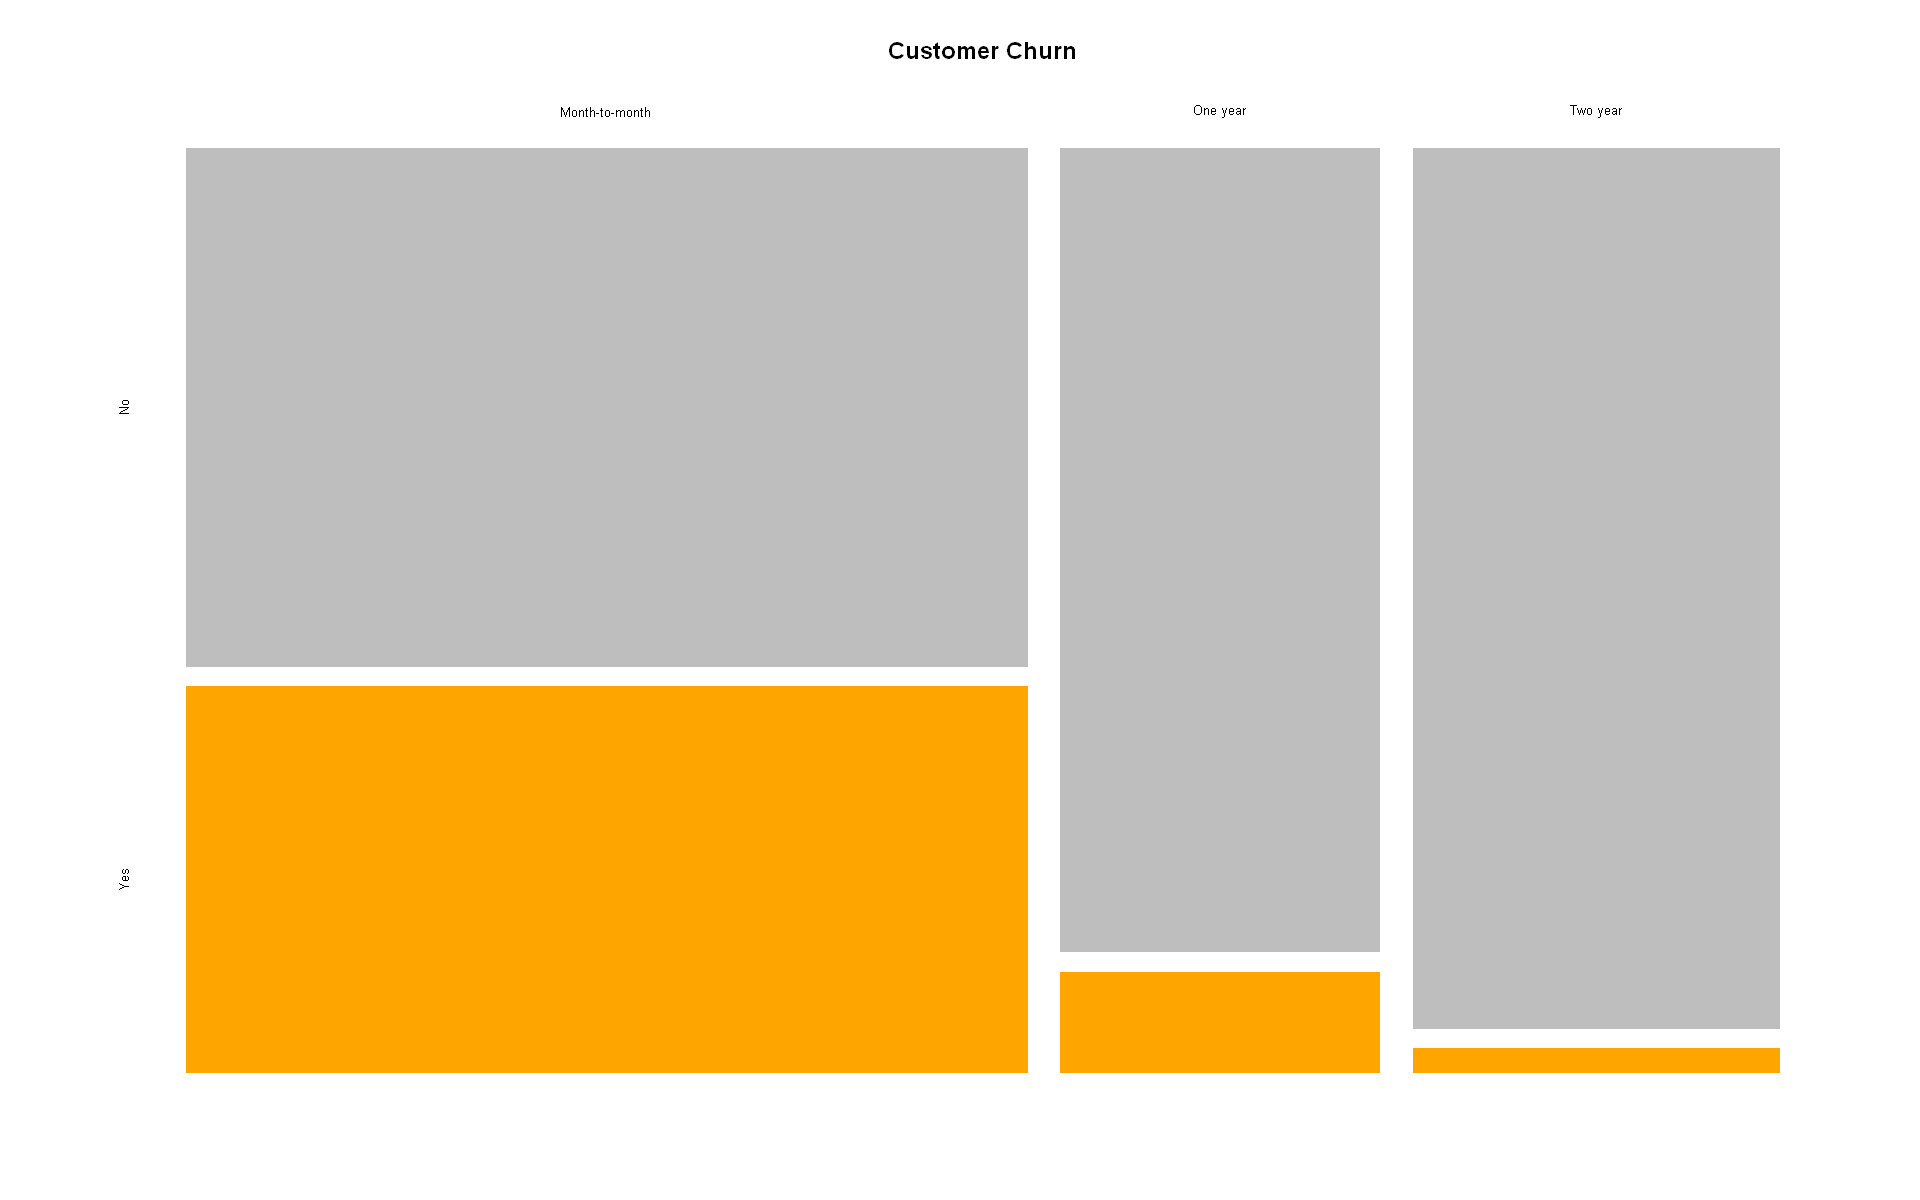

In [71]:
plot(table(churn$Contract, churn$Churn), col=c('gray','orange'), 
     border = 'white', main = "Customer Churn")

- <B>Partner:</B> those who are single tend to choose Month-to-month contracts and we saw previously this is a high risk factor.

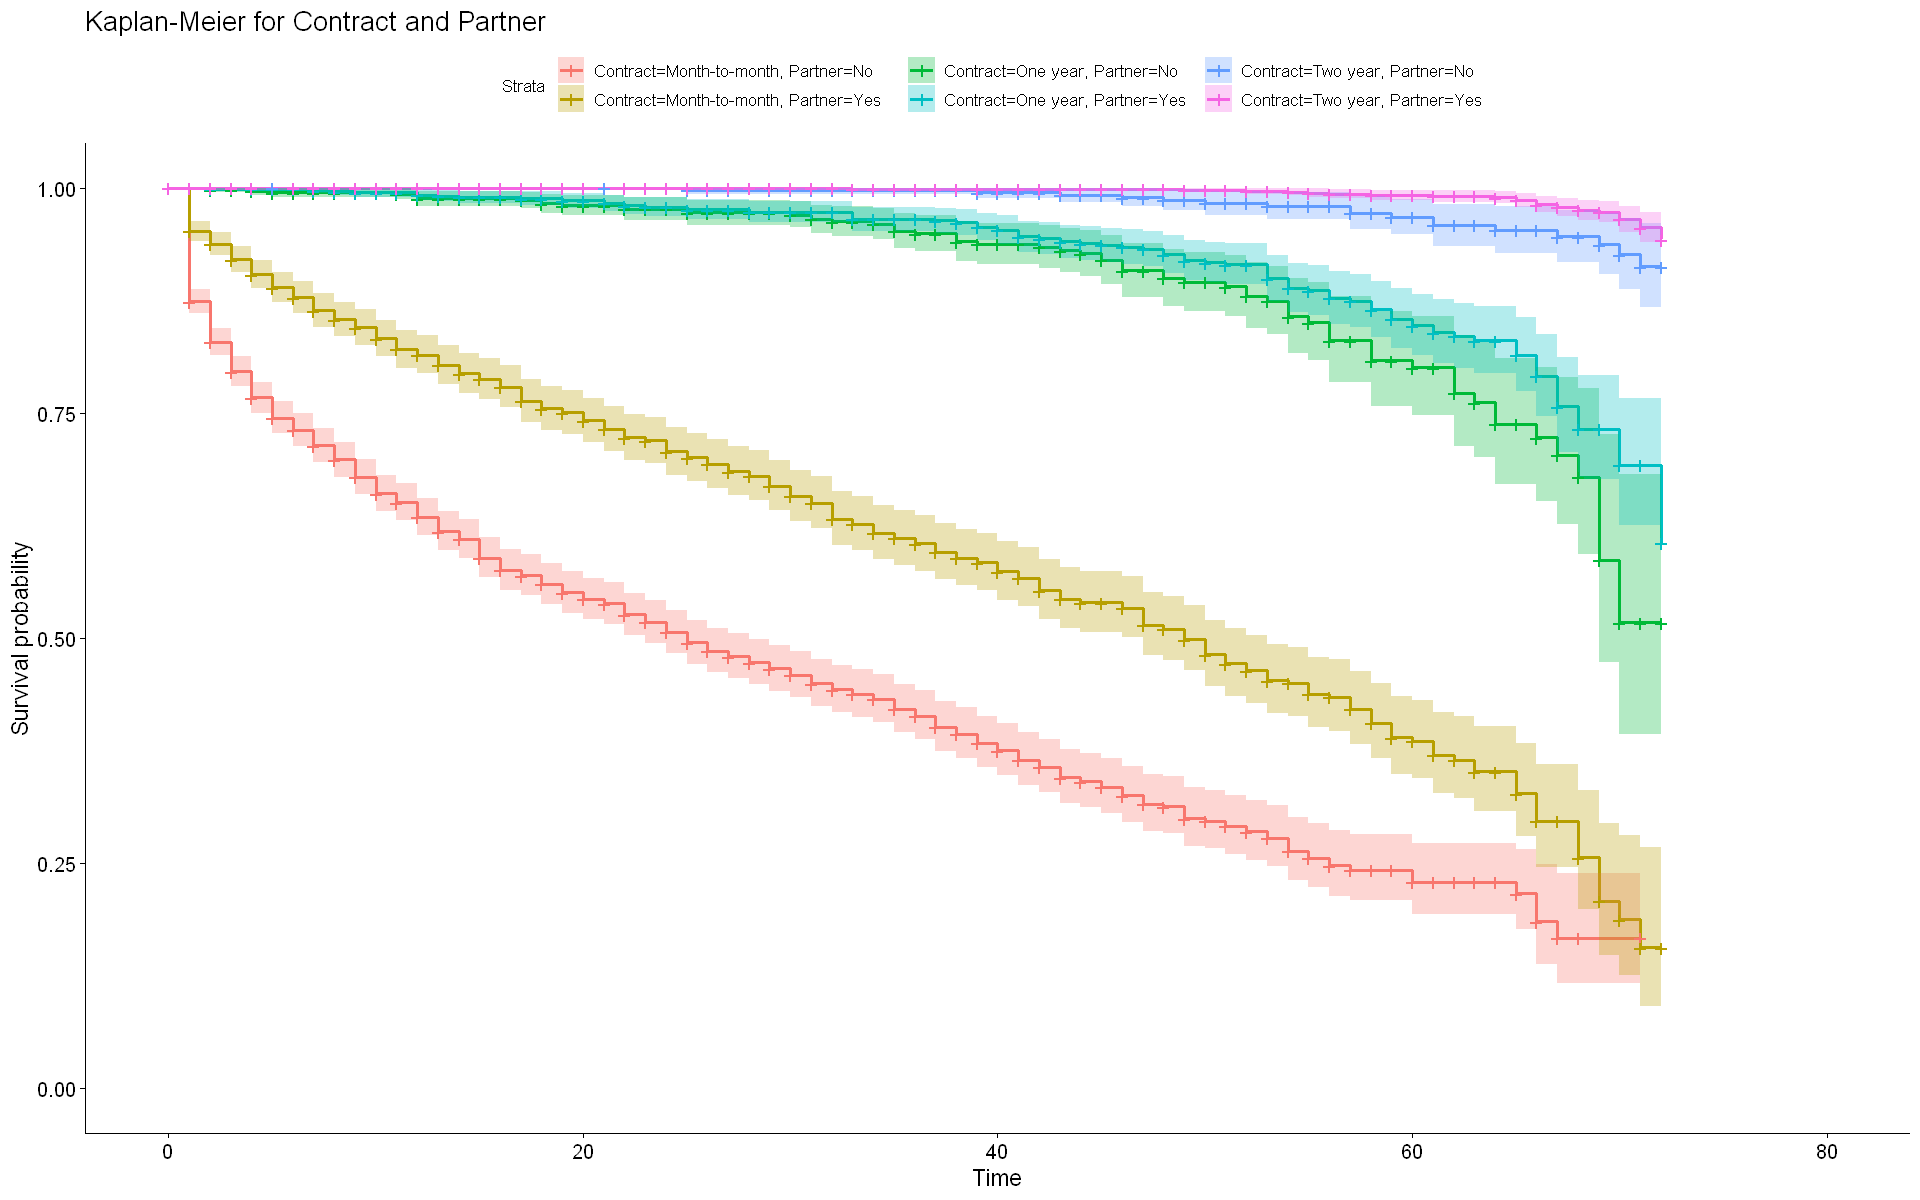

In [72]:
ggsurvplot(survfit(Surv(tenure, event) ~ Contract + Partner, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Contract and Partner', xlab = 'Time')

- <B> Payment Method:</B> if the customer is required to interact to pay the bills monthly the hazard increases substantially, especially attention should be given to electronic checks.

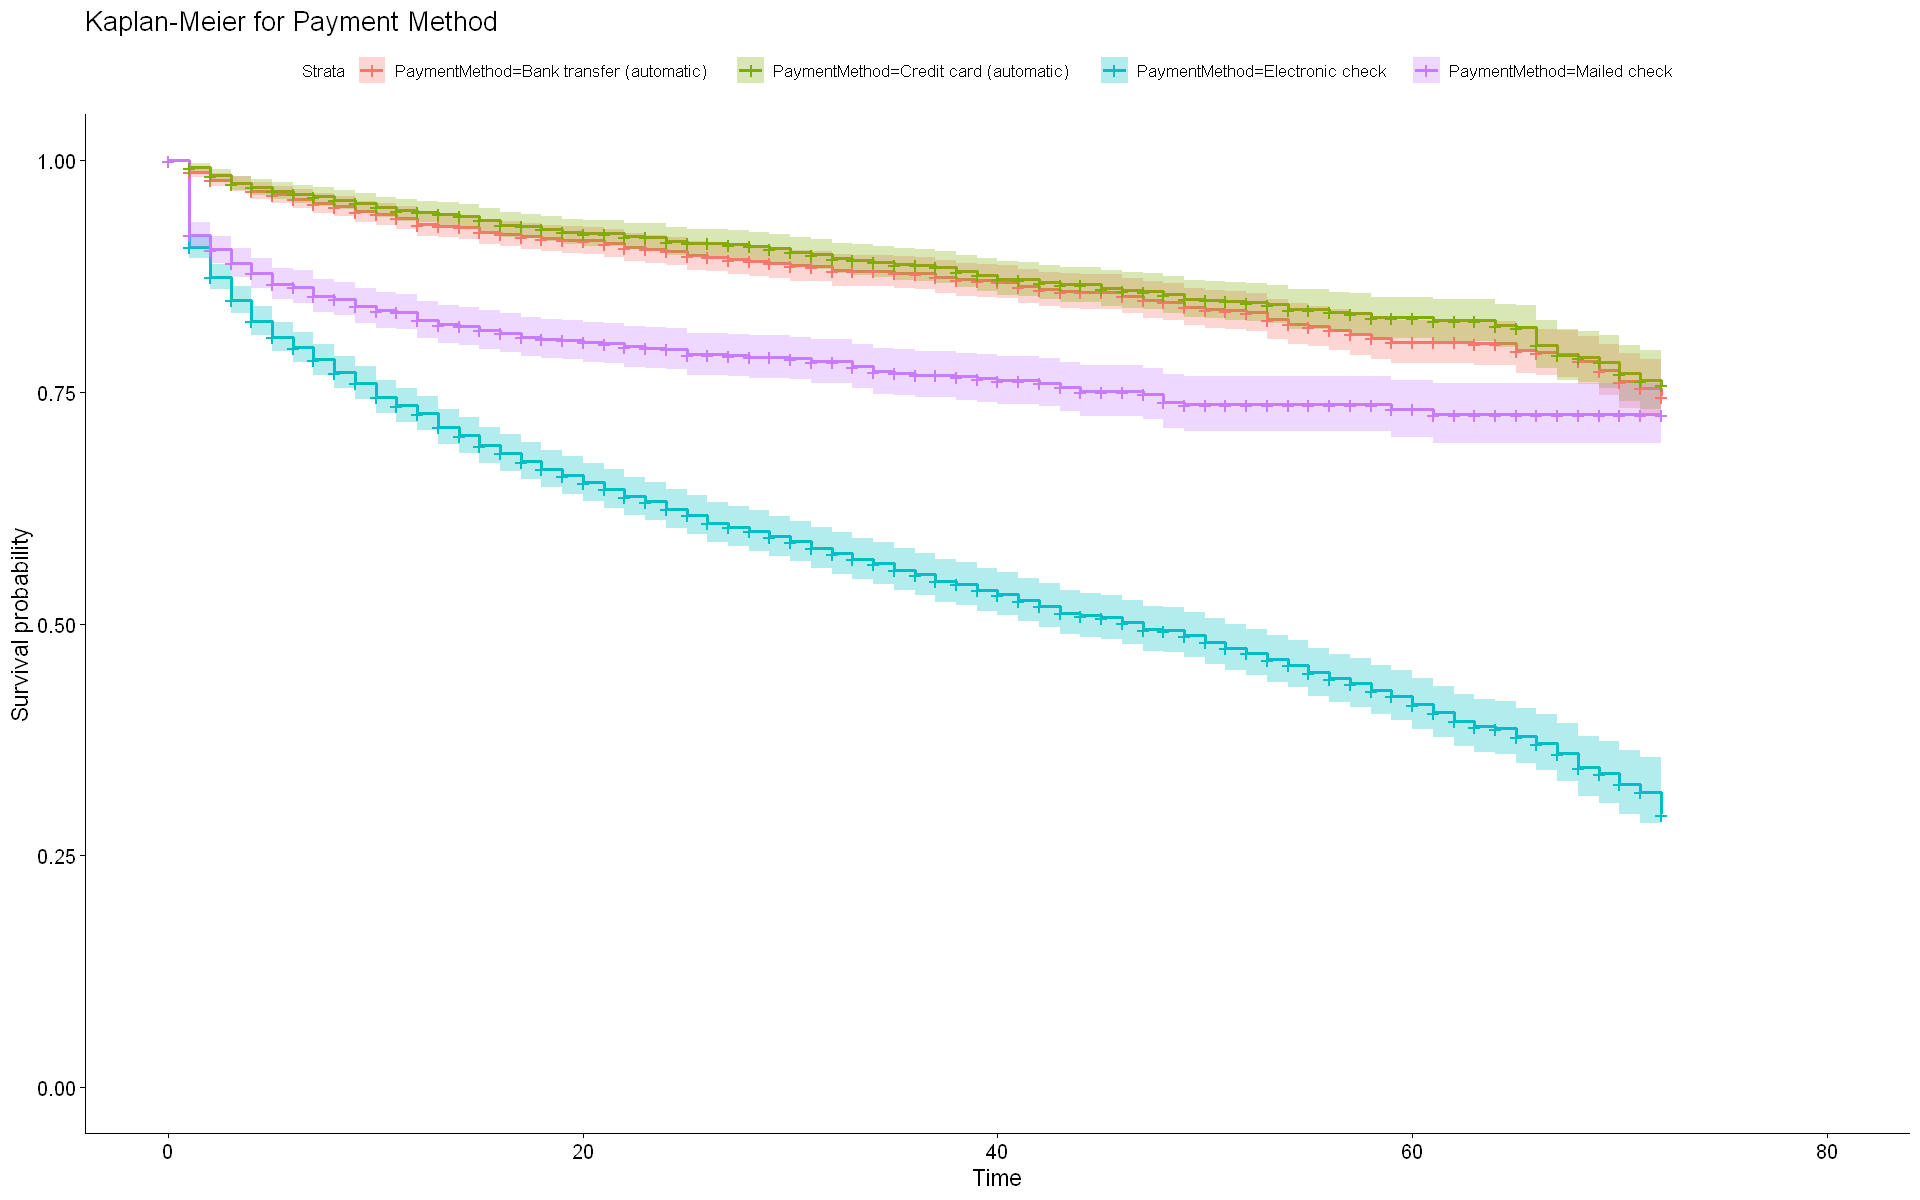

In [73]:
ggsurvplot(survfit(Surv(tenure, event) ~ PaymentMethod, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Payment Method', xlab = 'Time')

- <B>Services: </B> when it comes to services it deserves an study to check the best package for the customer segments. With the data available we can say that there is higher risk for:
       a) fiber optic customers, in their case the survival reach 75% in less than 1.5 year, while for DSL the curve is much more slower and reaches the same plateau after 5.5 years.
       b) customers who do not have technical support for internet, in less than one year there is 20% of churn.
       c) the absence of services related to risk mitigation (device protection, online security and online backup). In 18 months the company looses 50% of customers who do not have any of these services.

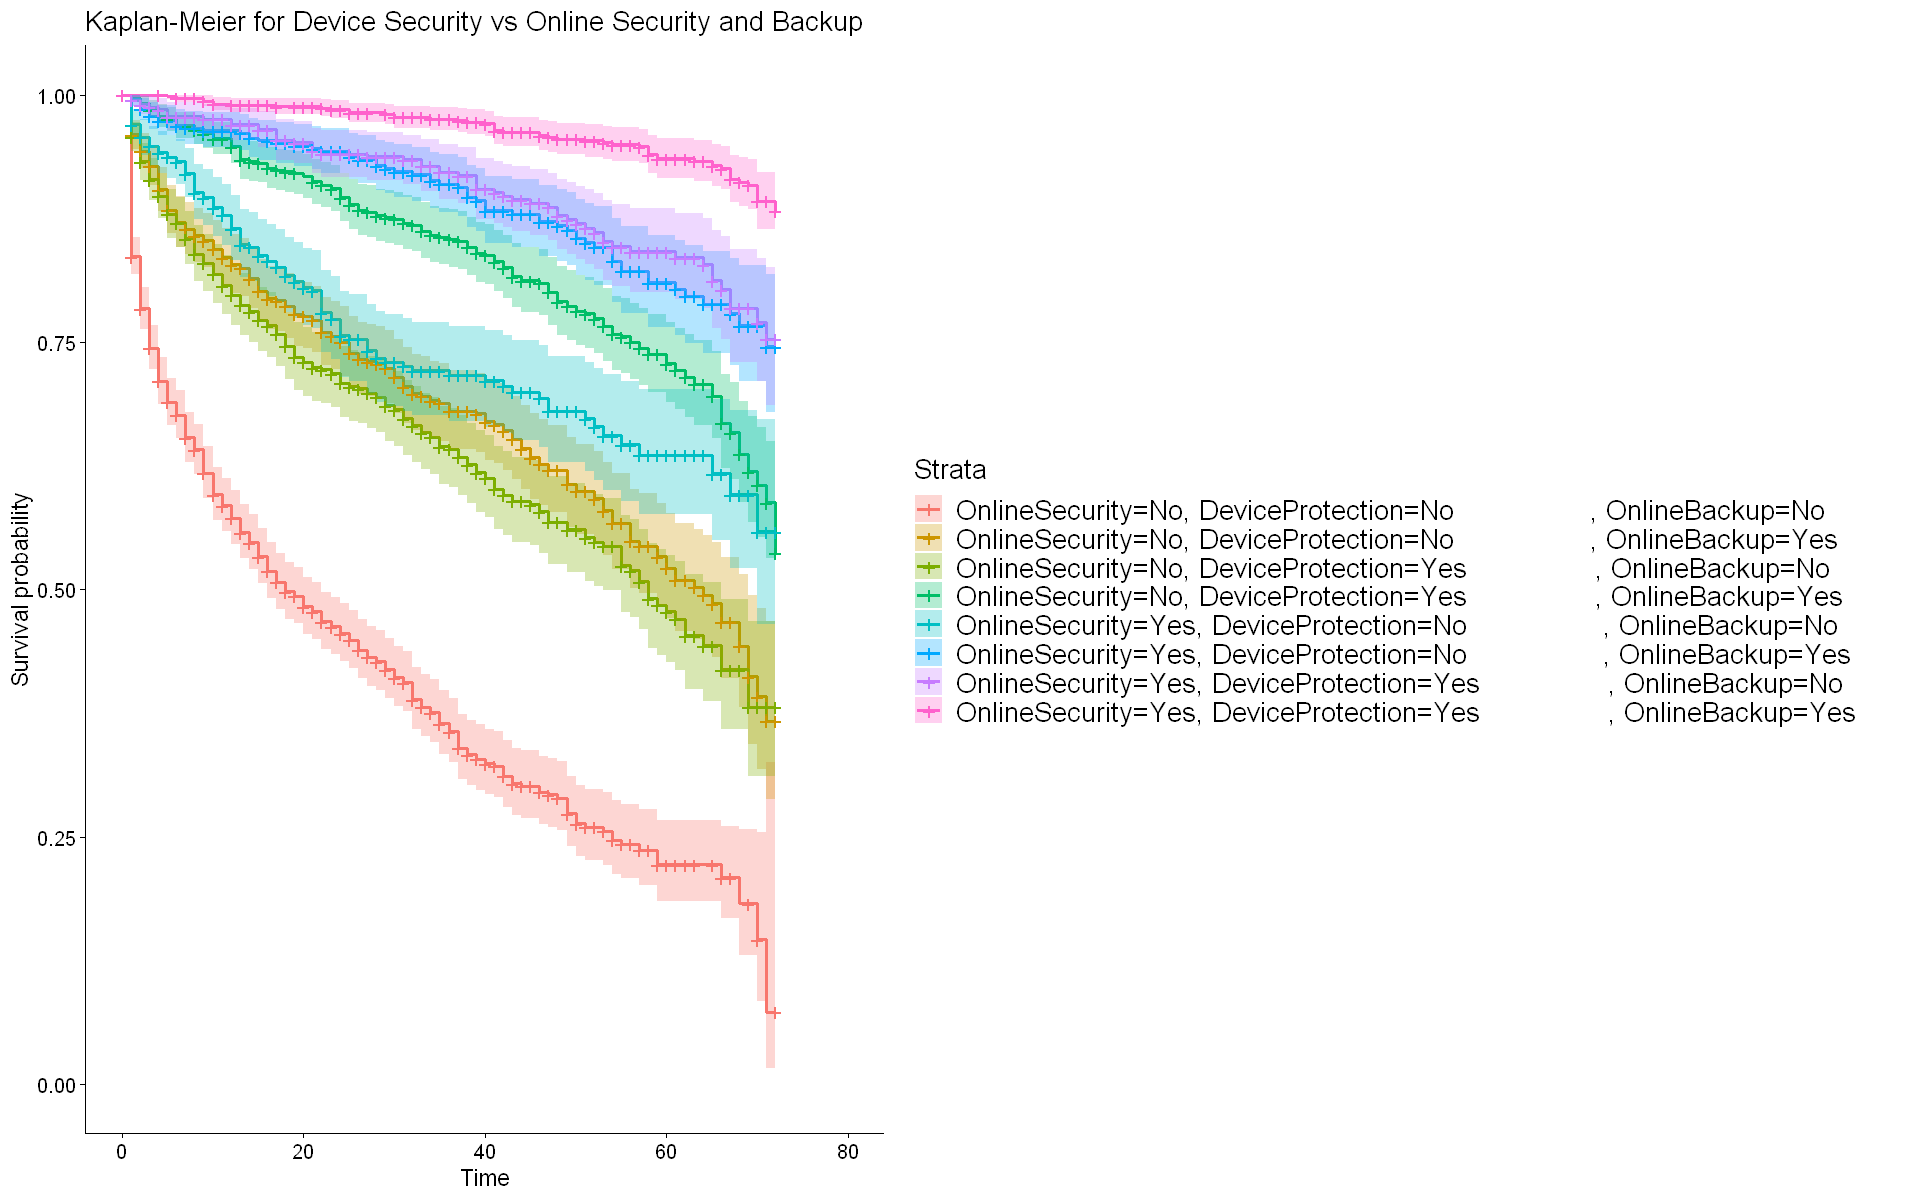

In [131]:
ggsurvplot(survfit(Surv(tenure, event) ~ OnlineSecurity +DeviceProtection+OnlineBackup, 
                   data = churn[churn$InternetService!='No',]), conf.int = TRUE,
           title = 'Kaplan-Meier for Device Security vs Online Security and Backup', xlab = 'Time', legend = 'right', 
           font.legend = c(16, "plain", "black"))

In [136]:
coxph.full.model =  coxph(Surv(tenure, event) ~ gender + SeniorCitizen + Partner + 
                          Dependents + PhoneService + MultipleLines + InternetService +
                          OnlineSecurity + OnlineBackup + DeviceProtection + 
                          TechSupport + StreamingTV + StreamingMovies + Contract +
                          PaperlessBilling + PaymentMethod,
                          data = churn)
summary(coxph.full.model)

Call:
coxph(formula = Surv(tenure, event) ~ gender + SeniorCitizen + 
    Partner + Dependents + PhoneService + MultipleLines + InternetService + 
    OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + 
    StreamingTV + StreamingMovies + Contract + PaperlessBilling + 
    PaymentMethod, data = churn)

  n= 7043, number of events= 1869 

                                         coef exp(coef) se(coef)       z
genderMale                           -0.08564   0.91793  0.04643  -1.844
SeniorCitizen1                       -0.07165   0.93085  0.05656  -1.267
PartnerYes                           -0.51737   0.59609  0.05508  -9.393
DependentsYes                        -0.05446   0.94700  0.06879  -0.792
PhoneServiceYes                       0.09327   1.09776  0.10071   0.926
MultipleLinesNo phone service              NA        NA  0.00000      NA
MultipleLinesYes                     -0.45807   0.63251  0.05325  -8.602
InternetServiceFiber optic            0.38650   1.47182  0.072